In [1]:
import torch
from data_utils import dataset_x
from data import Augmentation, SSLImageDataset
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms

import ffcv
from ffcv_ssl import DivideImageBy255

/home/erlandbo/anaconda3/envs/ffcv-ssl/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
basedataset = "cifar10"
use_ffcv = False
batchsize = 4
numworkers = 10

In [3]:



def build_ffcv_nonsslloader(write_path, imgsize, mean, std, batchsize, numworkers, mode="train"):
    image_pipeline1 = [
        ffcv.fields.rgb_image.SimpleRGBImageDecoder(),
        ffcv.transforms.ops.ToTensor(),
        #ToDevice(torch.device('cuda:0'), non_blocking=True),
        ffcv.transforms.ops.ToTorchImage(convert_back_int16=False),
        DivideImageBy255(torch.float32),
        torchvision.transforms.Normalize(mean, std)
        #ffcv.transforms.normalize.NormalizeImage(mean=np.array(mean)*255.0, std=np.array(std)*255.0, type=np.float32)
    ]

    label_pipeline = [
        ffcv.fields.basics.IntDecoder(),
        ffcv.transforms.ops.ToTensor(),
        ffcv.transforms.common.Squeeze(1),
        #ToDevice(torch.device('cuda:0'), non_blocking=True),  # not int on gpu
    ]

    loader = ffcv.loader.Loader(
        write_path,
        num_workers=numworkers,
        batch_size=batchsize,
        pipelines={
            "image": image_pipeline1,
            "label": label_pipeline,
        },
        order=OrderOption.RANDOM if mode == 'train' else OrderOption.SEQUENTIAL,
        drop_last=False,
        os_cache=True,
        seed=42
    )
    return loader

In [4]:
train_dataset, test_dataset, num_classes , imgsize, mean, std = dataset_x(basedataset)
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
if not use_ffcv:

    test_augmentation = Augmentation(imgsize, mean, std, mode="test", num_views=1)
    train_dataset.transform = test_dataset.transform = test_augmentation
    trainloader = DataLoader(train_dataset, batch_size=batchsize, num_workers=numworkers,shuffle=False, pin_memory=True, drop_last=False)
    testloader = DataLoader(test_dataset, batch_size=batchsize, num_workers=numworkers, shuffle=False, pin_memory=True, drop_last=False)
else:
    from ffcv_ssl import build_ffcv_nonsslloader

    trainloader = build_ffcv_nonsslloader(
        write_path=f"output/{basedataset}/trainds.beton",
        mean=mean,
        std=std,
        imgsize=imgsize,
        batchsize=batchsize,
        numworkers=numworkers,
        mode="test"
    )
    testloader = build_ffcv_nonsslloader(
        write_path=f"output/{basedataset}/testds.beton",
        mean=mean,
        std=std,
        imgsize=imgsize,
        batchsize=batchsize,
        numworkers=numworkers,
        mode="test"
    )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [5]:
plaindataset = torchvision.datasets.CIFAR10(
        root="./data",
        train=True,
        transform=transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]),
        download=True
    )

vizdataloader = DataLoader(plaindataset, batch_size=batchsize, shuffle=False)


Files already downloaded and verified


In [6]:
len(next(iter(trainloader)))

2

In [7]:
imgs_aug1, y = next(iter(trainloader))
imgs_orig, labels = next(iter(vizdataloader))

In [8]:
y

tensor([6, 9, 9, 4])

In [9]:
labels

tensor([6, 9, 9, 4])

In [10]:

label2name = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck"
]

def plot_imgs(imgs_orig, imgs_aug1, labels):
    maximg = min(4, imgs_orig.shape[0])
    imgs_orig, imgs_aug1, labels = imgs_orig[:maximg], imgs_aug1[:maximg], labels[:maximg]
    fig, ax = plt.subplots(maximg, 2, figsize=(25, 25))
    for i, (img_orig, img_aug1) in enumerate(zip(imgs_orig, imgs_aug1)):
        ax[i, 0].imshow(img_orig.permute(1,2,0) * 0.5 + 0.5)
        ax[i, 1].imshow(img_aug1.permute(1,2,0) * 0.5 + 0.5)
        
        ax[i, 0].set_title("Original " + label2name[int(labels[i])], fontsize=16, pad=5)
        ax[i, 1].set_title("Augmented " + label2name[int(labels[i])] + " 1", fontsize=16, pad=5)
        
    plt.tight_layout()
    fig.show()

/tmp/ipykernel_99599/191006225.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


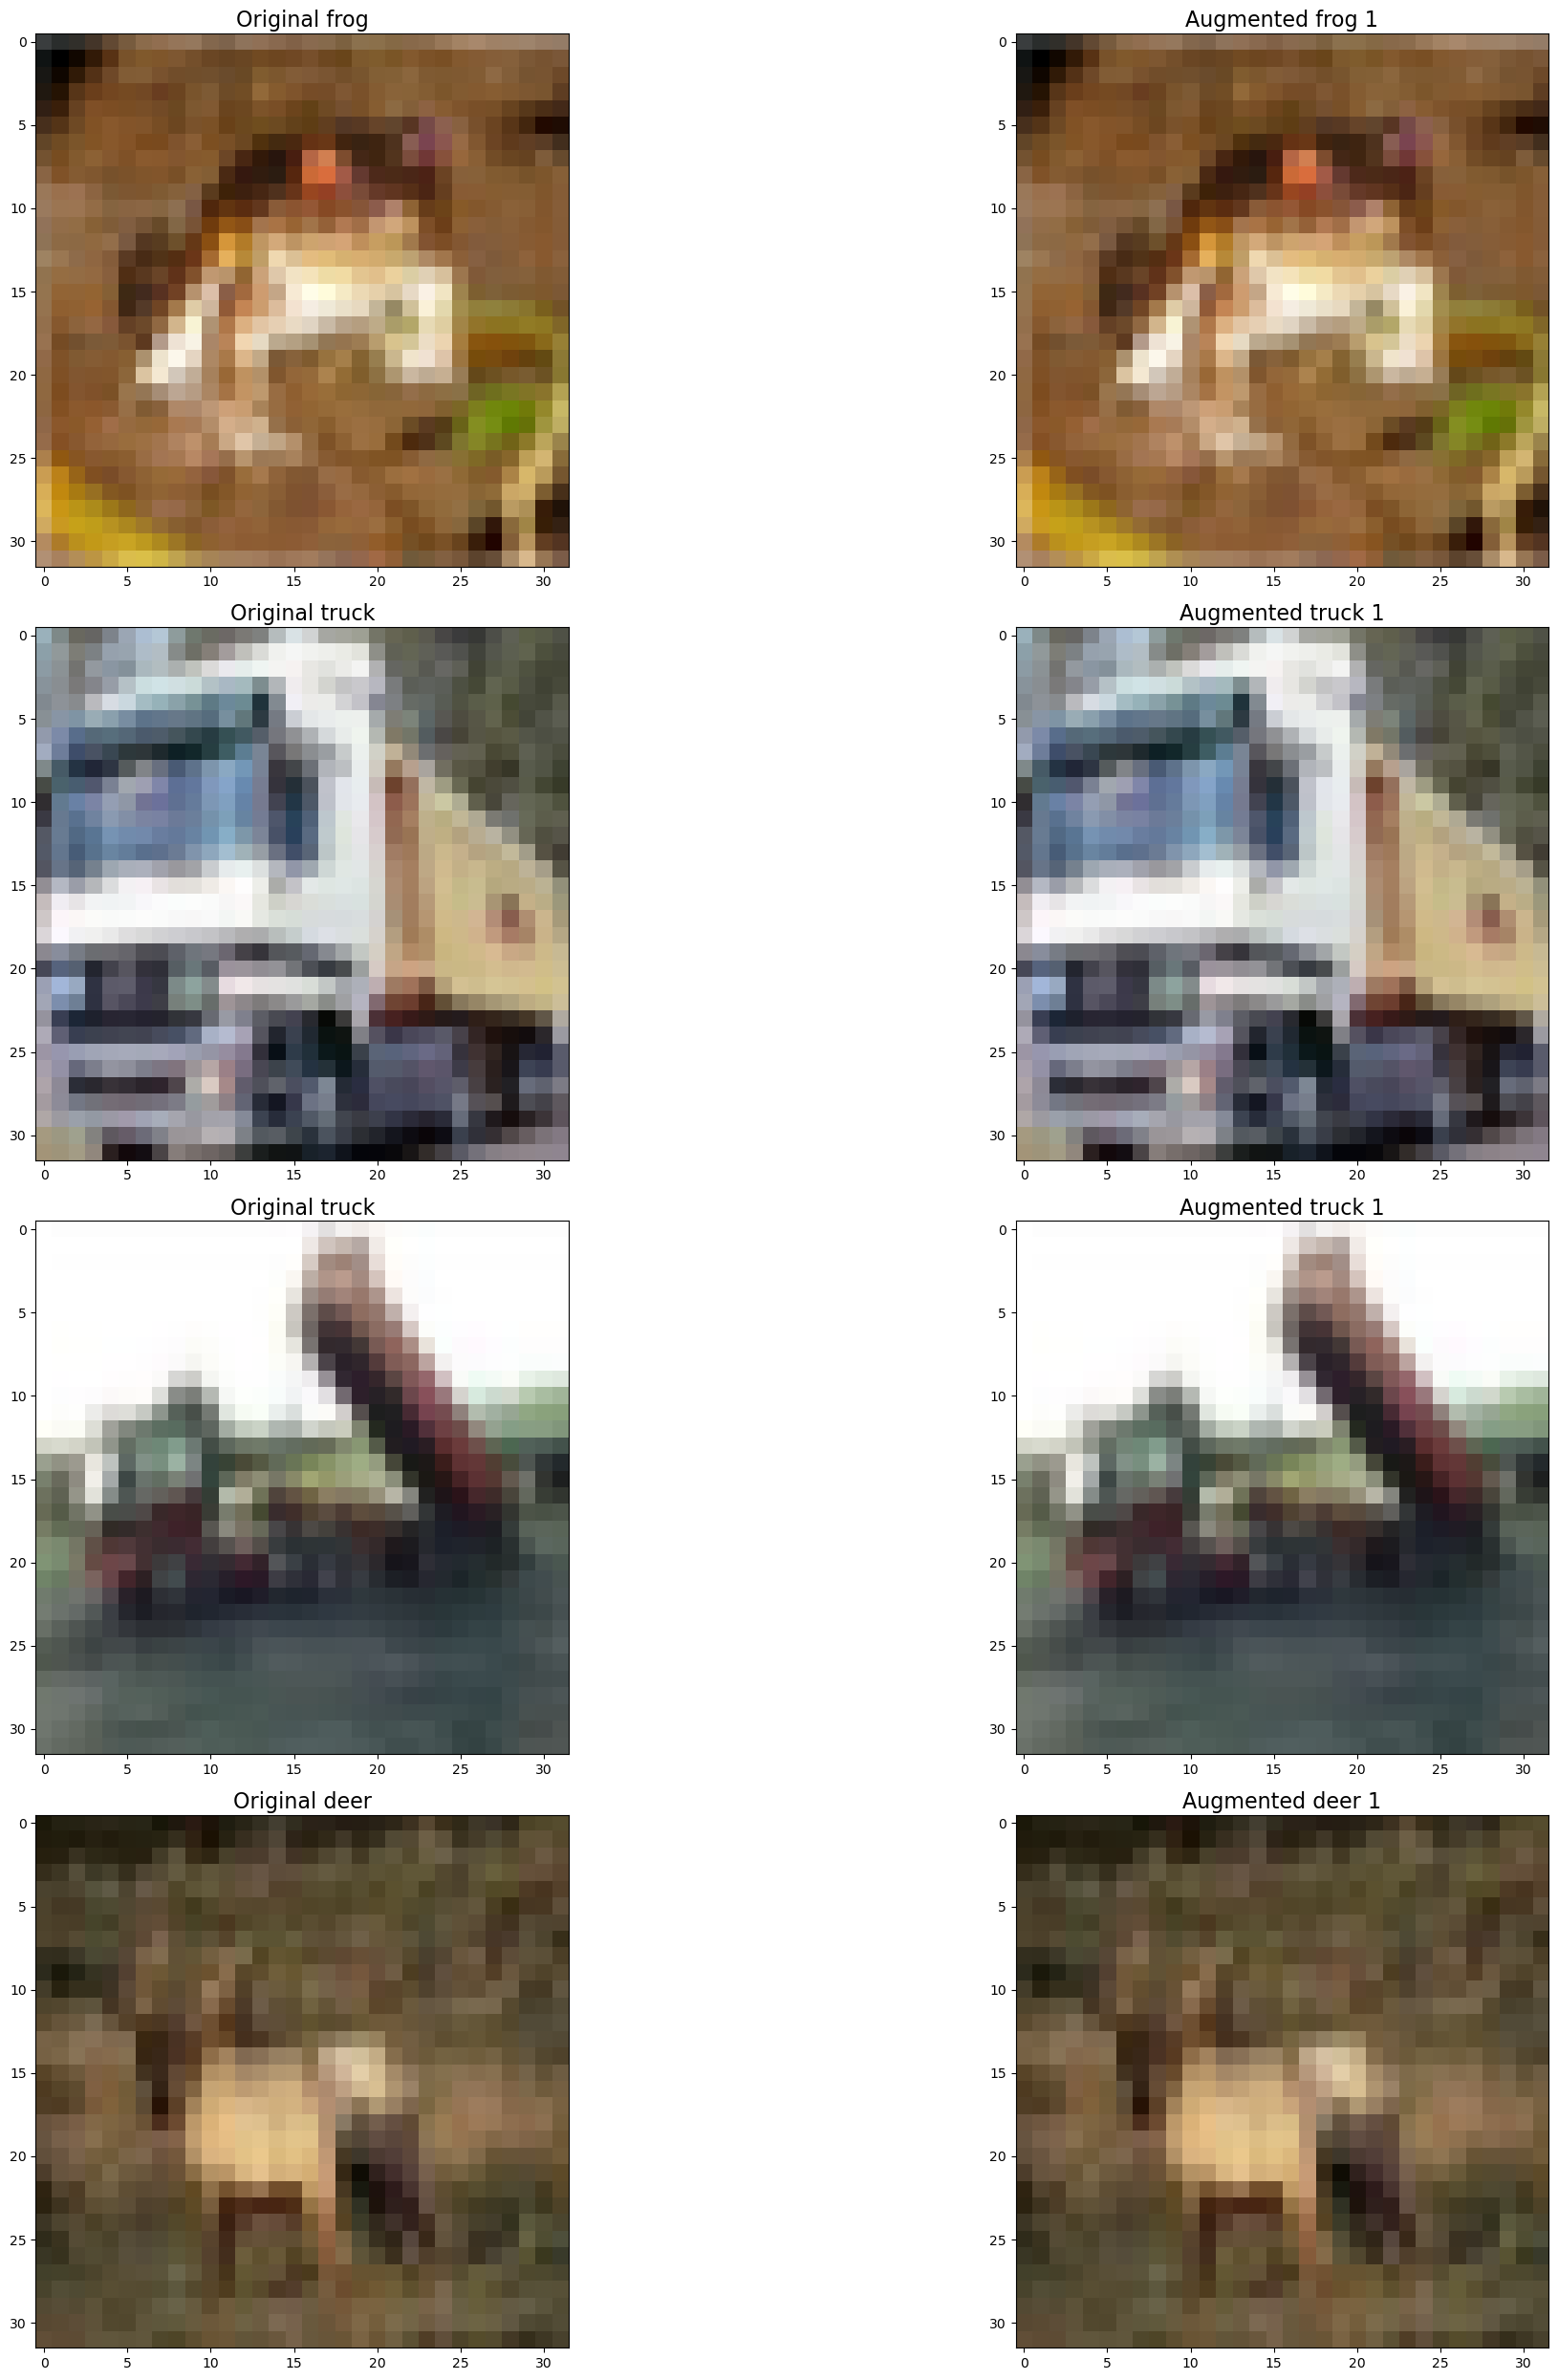

In [11]:
plot_imgs(imgs_orig, imgs_aug1, labels)

/tmp/ipykernel_99599/191006225.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


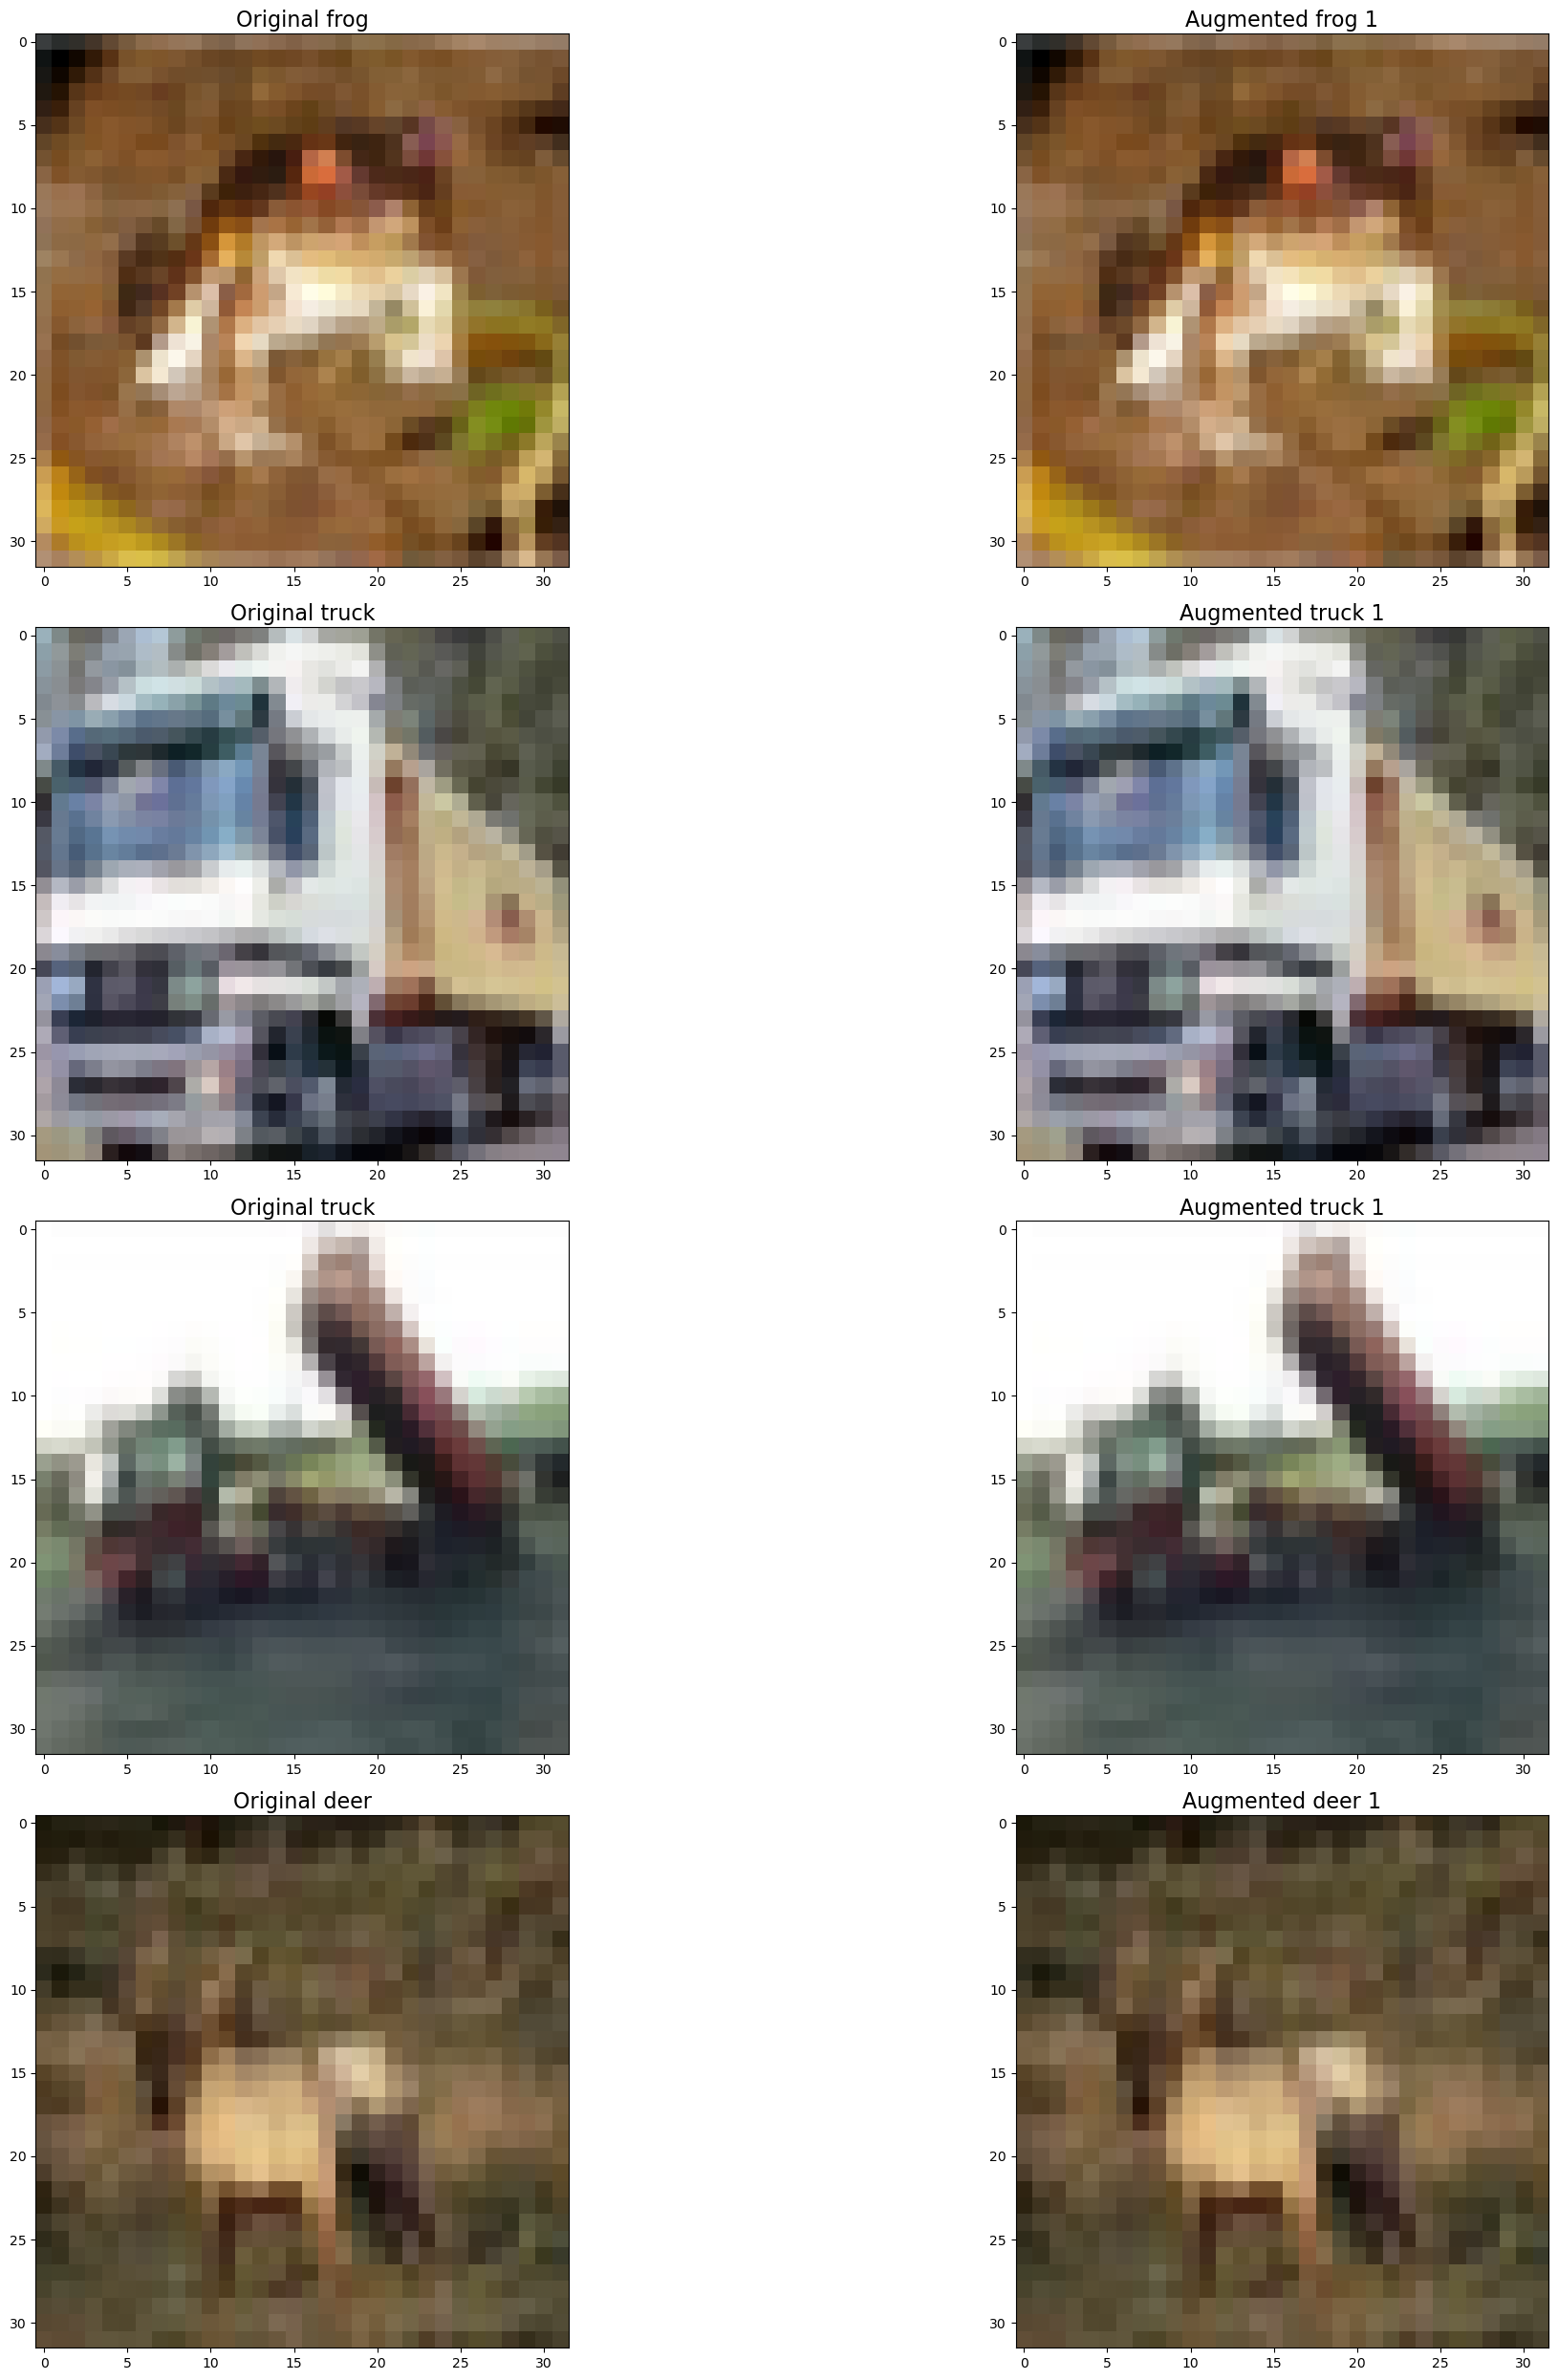

In [12]:
plot_imgs(imgs_orig, imgs_aug1, labels)